## Setup

Load libraries

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pmdarima import arima
from sklearn import set_config
from matplotlib import pyplot as plt
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import STL


set_config(
    display='diagram',
    transform_output="pandas"
)

## Load Data

Data Source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption).

In [2]:
## create data directory

os.makedirs('./data', exist_ok=True)

## set data path
path= os.path.join('data', 'individual+household+electric+power+consumption.zip')

power_consumption_data = (
    pd.read_csv(
        filepath_or_buffer=path,
        compression='zip',
        header='infer',
        sep=';',
        na_values=['?', 'nan'],
        low_memory=False
    )
    .assign(datetime=lambda x: pd.to_datetime(x['Date'] + ' ' + x['Time'], dayfirst=True))
    .set_index('datetime')
    .drop(columns=['Date', 'Time'])
)

power_consumption_data.info()
power_consumption_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Feature Engineering

### Explore Missing Observations

* Check Missing Observations

In [3]:
power_consumption_data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [4]:
n_missing=power_consumption_data.isnull().any(axis=1).sum()
print(f"Number of rows with at least one missing value: {n_missing}")

Number of rows with at least one missing value: 25979


All variables have missing observations. In data analytics, there are two options for dealing with missing data:

1. We can drop all rows with at least one missing entry.
2. We can impute the mssing values - so that we do not throw away valuable instances.

Because our data is time series, dropping rows with missing entries is not feasible - it will disturb the autocorrelation between instances. There are a number of way of filling missing values for time series data:

* Last observation carried forward.
* Next observation carries backward.
* Rolling statistics (weighted moving average, weighted moving average, exponential moving average).
* K-Nearest Neighbors (KNN) imputer.
* Interpolation

For this work, we will use intepolation.

In [5]:
## fill missing observations with interpolated values

no_na_df=power_consumption_data.interpolate(method='time')

n_missing=no_na_df.isnull().any(axis=1).sum()
print(f"Number of rows with at least one missing value after interpolation: {n_missing}")

Number of rows with at least one missing value after interpolation: 0


### Resampling

The aim of this project is to forecast power consumption 24 hours into the future, but our data is collected every minute. We will:

1. Resample our data hourly.
2. Drop the first and last hours of data in the dataframe because they do not have up to 24 hours of data.

In [6]:
## resample data to hourly frequency

hourly_power_consumption=no_na_df.resample('h').sum()

## drop first and last hour of data
hourly_power_consumption=hourly_power_consumption.iloc[1:-1]

hourly_power_consumption.info()
hourly_power_consumption.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34587 entries, 2006-12-16 18:00:00 to 2010-11-26 20:00:00
Freq: h
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34587 non-null  float64
 1   Global_reactive_power  34587 non-null  float64
 2   Voltage                34587 non-null  float64
 3   Global_intensity       34587 non-null  float64
 4   Sub_metering_1         34587 non-null  float64
 5   Sub_metering_2         34587 non-null  float64
 6   Sub_metering_3         34587 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0
2006-12-16 22:00:00,132.008,3.370,14325.60,571.4,0.0,8.0,266.0


### Add time as Usable Features

To encode the time as a usable feature in deep learning models, the `datetime` string must be transformed to capture the cyclical nature of time. This transformation involves converting the `datetime` into a numerical value representing the number of seconds, followed by applying a sine transformation to capture the cyclical pattern of a day, bounded between -1 and 1. To distinguish between morning and afternoon, a cosine transformation is also applied, as it's out of phase with the sine function. This combined sine-cosine encoding method preserves the cyclical property of time within a day, effectively handling the inherent cyclic patterns in time series data, such as differentiating between various times of the day and maintaining the continuity and proximity between time points.

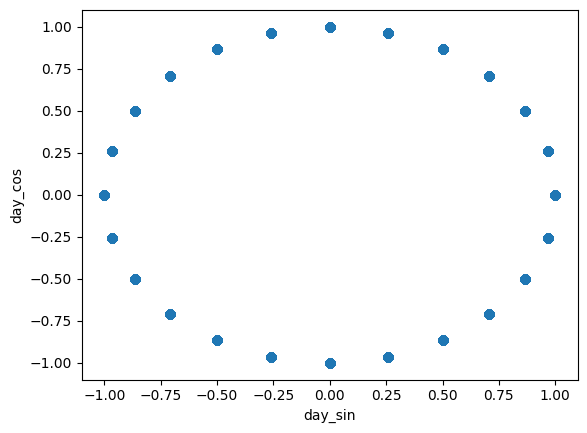

In [7]:
timestamp_s=hourly_power_consumption.index.map(lambda x: datetime.datetime.timestamp(x))

hourly_power_consumption=hourly_power_consumption.assign(
    day_sin=np.sin(timestamp_s * (2 * np.pi / (24 * 60 * 60))).values,
    day_cos=np.cos(timestamp_s * (2 * np.pi / (24 * 60 * 60))).values,
)

plt.plot(hourly_power_consumption.day_sin, hourly_power_consumption.day_cos, 'o')
plt.xlabel('day_sin')
plt.ylabel('day_cos')
plt.show()

### Descriptive Statistics

In [8]:
hourly_power_consumption.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34587.0,65.413525,53.651407,7.440000,20.572000,4.819294e+01,94.722000,393.632000
Global_reactive_power,34587.0,7.418855,4.024071,0.023918,4.676000,6.428000e+00,8.970000,46.460000
Voltage,34587.0,14449.973628,180.088322,13550.070000,14350.695000,1.445848e+04,14561.340000,15114.120000
Global_intensity,34587.0,277.274921,224.579217,30.200000,91.000000,2.054000e+02,396.200000,1703.000000
Sub_metering_1,34587.0,66.570344,211.108972,0.000000,0.000000,0.000000e+00,0.000000,2902.000000
Sub_metering_2,34587.0,77.354656,250.104691,0.000000,0.000000,2.000000e+01,39.000000,2786.000000
Sub_metering_3,34587.0,386.532845,440.447840,0.000000,39.000000,9.900000e+01,845.000000,1471.470054
day_sin,34587.0,0.000024,0.707083,-1.000000,-0.707107,-2.718614e-16,0.707107,1.000000
day_cos,34587.0,0.000049,0.707151,-1.000000,-0.707107,7.697669e-16,0.707107,1.000000


## Data Splitting

* train: 70\%
* validation: 10\%
* test: 20\%

In [9]:
n=hourly_power_consumption.shape[0] # number of rows (sample size)

train=hourly_power_consumption.iloc[:int(n*0.80)]
test=hourly_power_consumption.iloc[int(n*0.80):]

## Time Series Plot

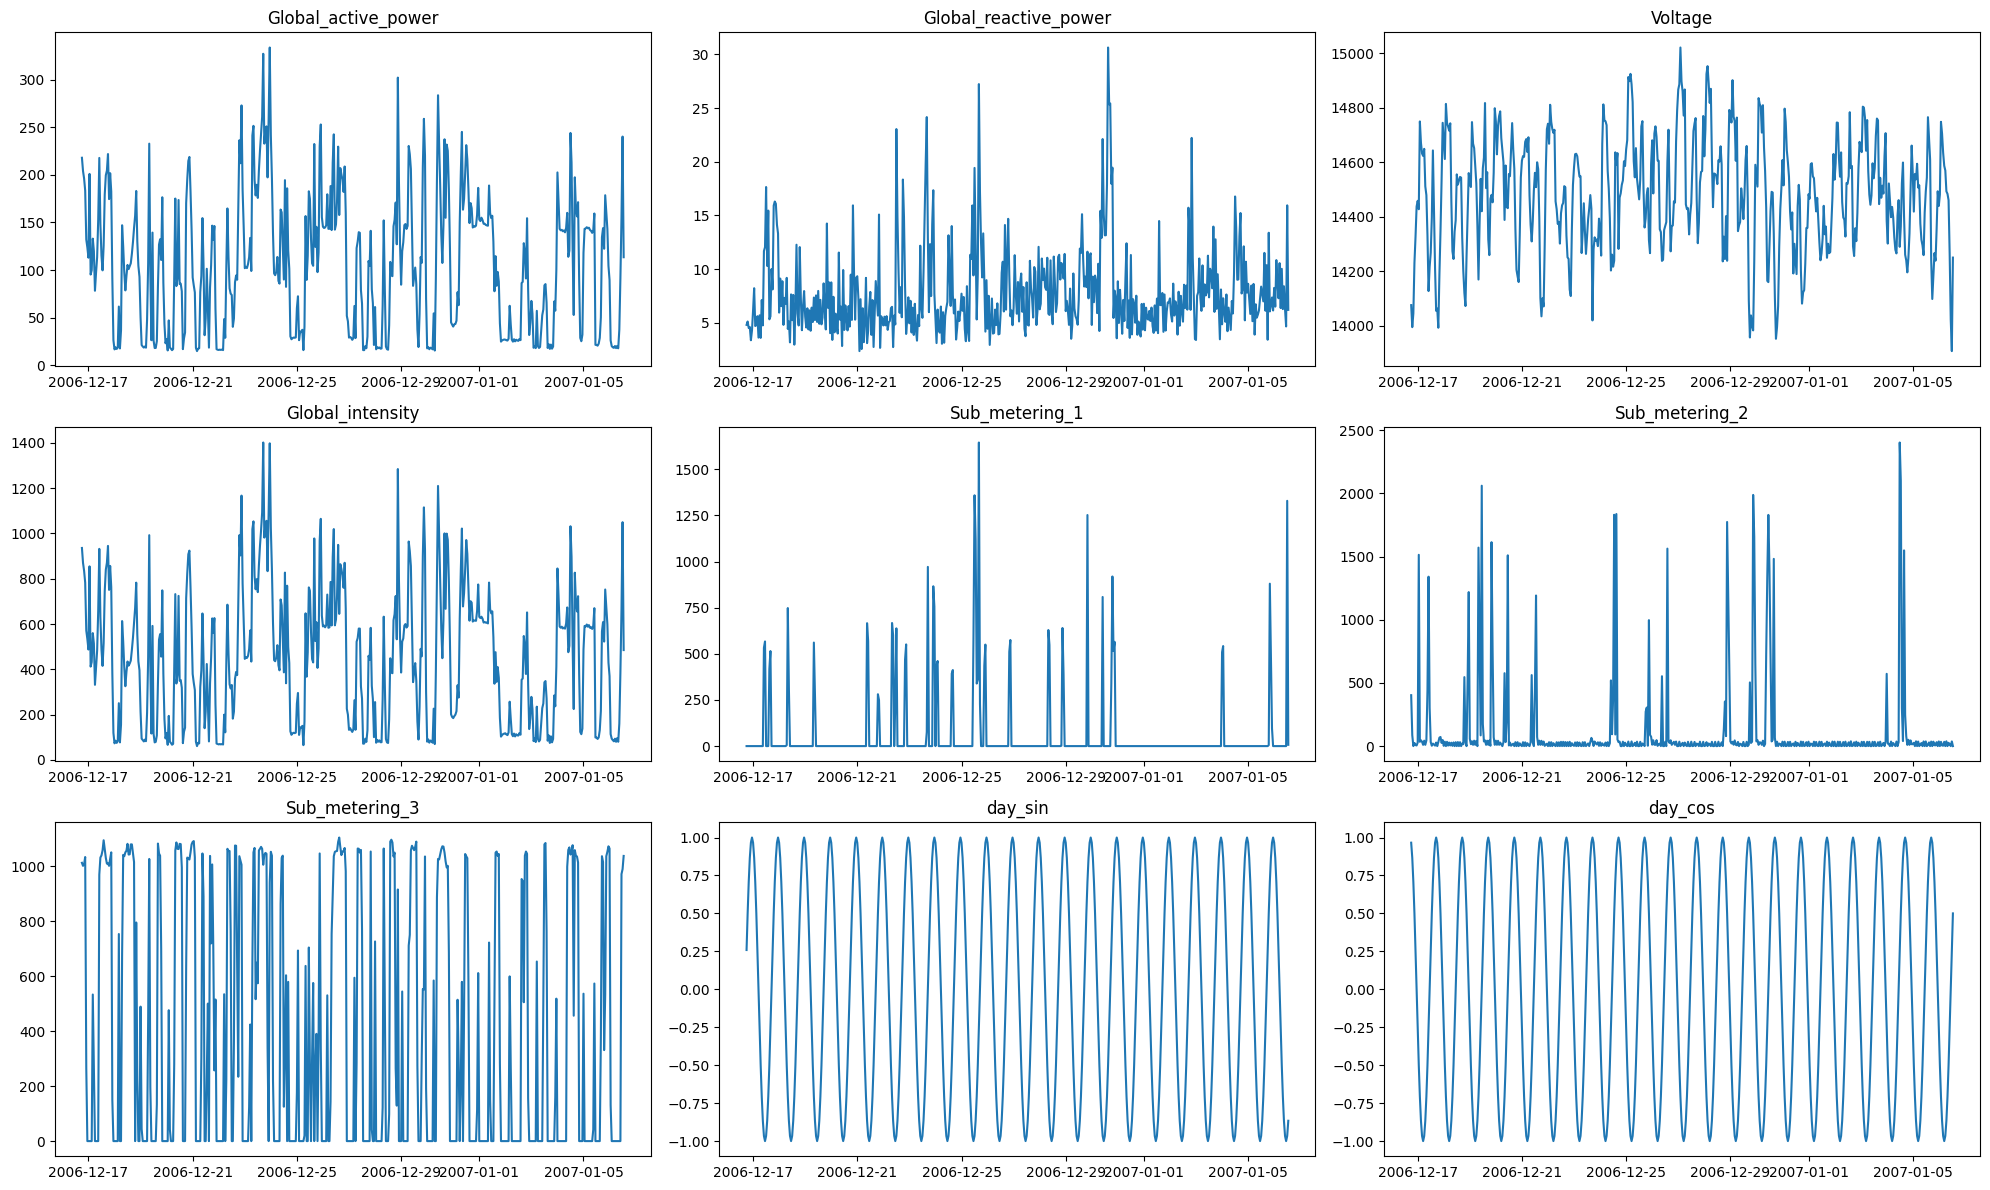

In [10]:
## time series plot of all variables (first 2000 observations)

plt.figure(figsize=(20,12))

for i, col in enumerate(train.columns):
    plt.subplot(3, 3, i+1)
    plt.plot(train[col].iloc[:500])

    plt.title(col)

plt.tight_layout()
plt.show()

## Check Correlations

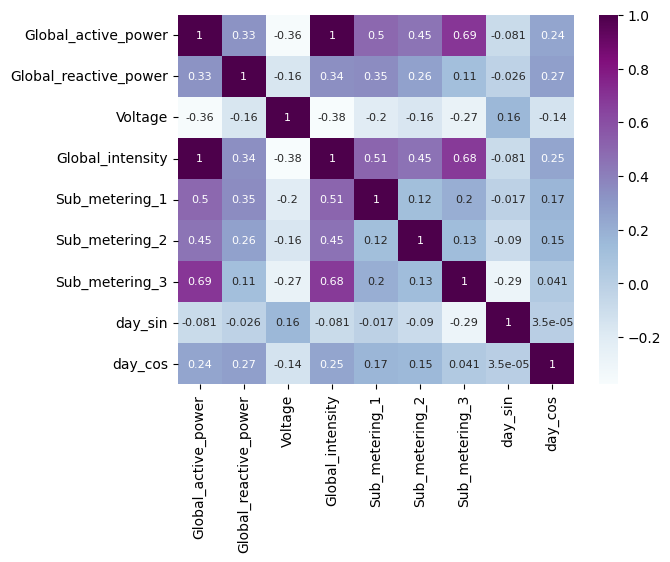

In [11]:
#sns.set(font_scale=0.7)
sns.heatmap(
    train.corr(), annot=True, 
    cmap='BuPu', annot_kws={'size': 8}
)
plt.show()

We do not seem to have multicollinearity here - no very high correlation between features.

## Check Seasonality

Our goal is to focus on the global active power consumption in a household, which will likely display some patterns of seasonality. It is anticipated that the usage of electrical power will decrease during nighttime hours. Moreover, power consumption might peak when residents return home from work over the course of the week. Therefore, it is a fair assumption that our target will exhibit some degree of seasonality.

The period of a time series is the length of the cycle that the data follows. The period is usually determined by the frequency of the observations. For hourly data, there can be two main periods:

1. **Daily Cycle:** If the data has patterns that repeat every day (24 hours), then the period is 24. 
2. **Weekly Cycle:** If the data has patterns that repeat every week, then the period is 24 hours/day * 7 days/week = 168 hours.

We will check both (visually and using statistical tests).

One straight forward approach is to decompose our time series into its different componenets. A time series data can be decomposed into three componenets (traditional statistics says 4):

1. **Drift**: An overall trend present in the time series. An example of a drift model is $y(t) = \mu t$.
2. **Seasonal componenet**: A periodic behavior existing in the time series.
3. **Random/irregular/Noise componenet**: The part of the time series remaining after removing drift and seasonality.

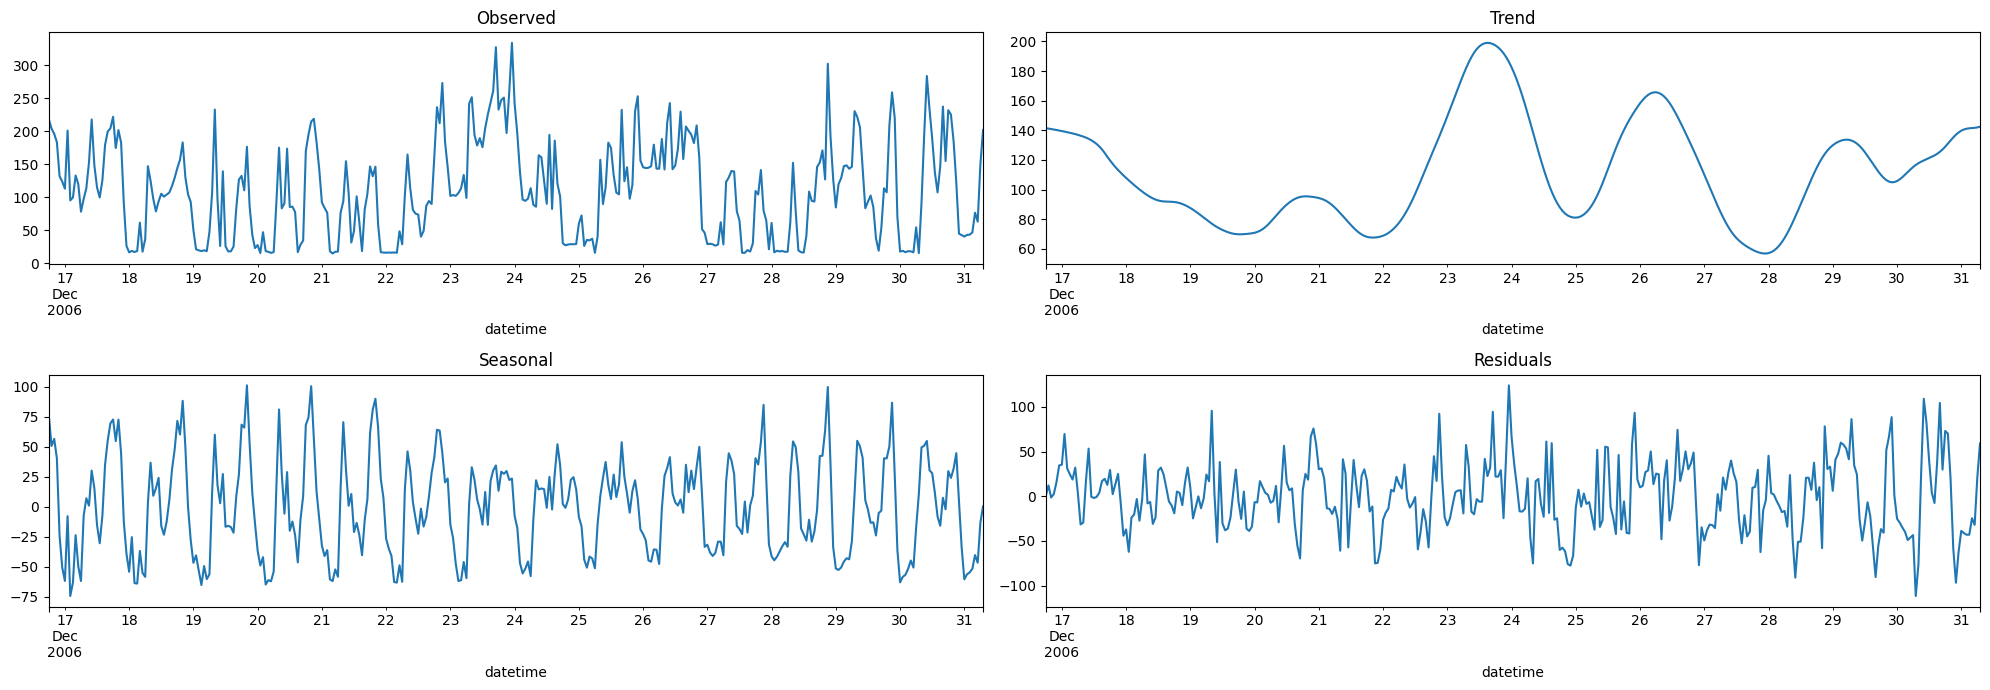

In [154]:
daily_decomposition = STL(train['Global_active_power'], period=24).fit()  # since the data is hourly, we use 24 hours as the period

plt.figure(figsize=(20,7))

plt.subplot(2,2,1)
daily_decomposition.observed.iloc[:350].plot()
plt.title('Observed')

plt.subplot(2,2,2)
daily_decomposition.trend.iloc[:350].plot()
plt.title('Trend')

plt.subplot(2,2,3)
daily_decomposition.seasonal.iloc[:350].plot()
plt.title('Seasonal')

plt.subplot(2,2,4)
daily_decomposition.resid.iloc[:350].plot()
plt.title('Residuals')

plt.tight_layout()
plt.show()

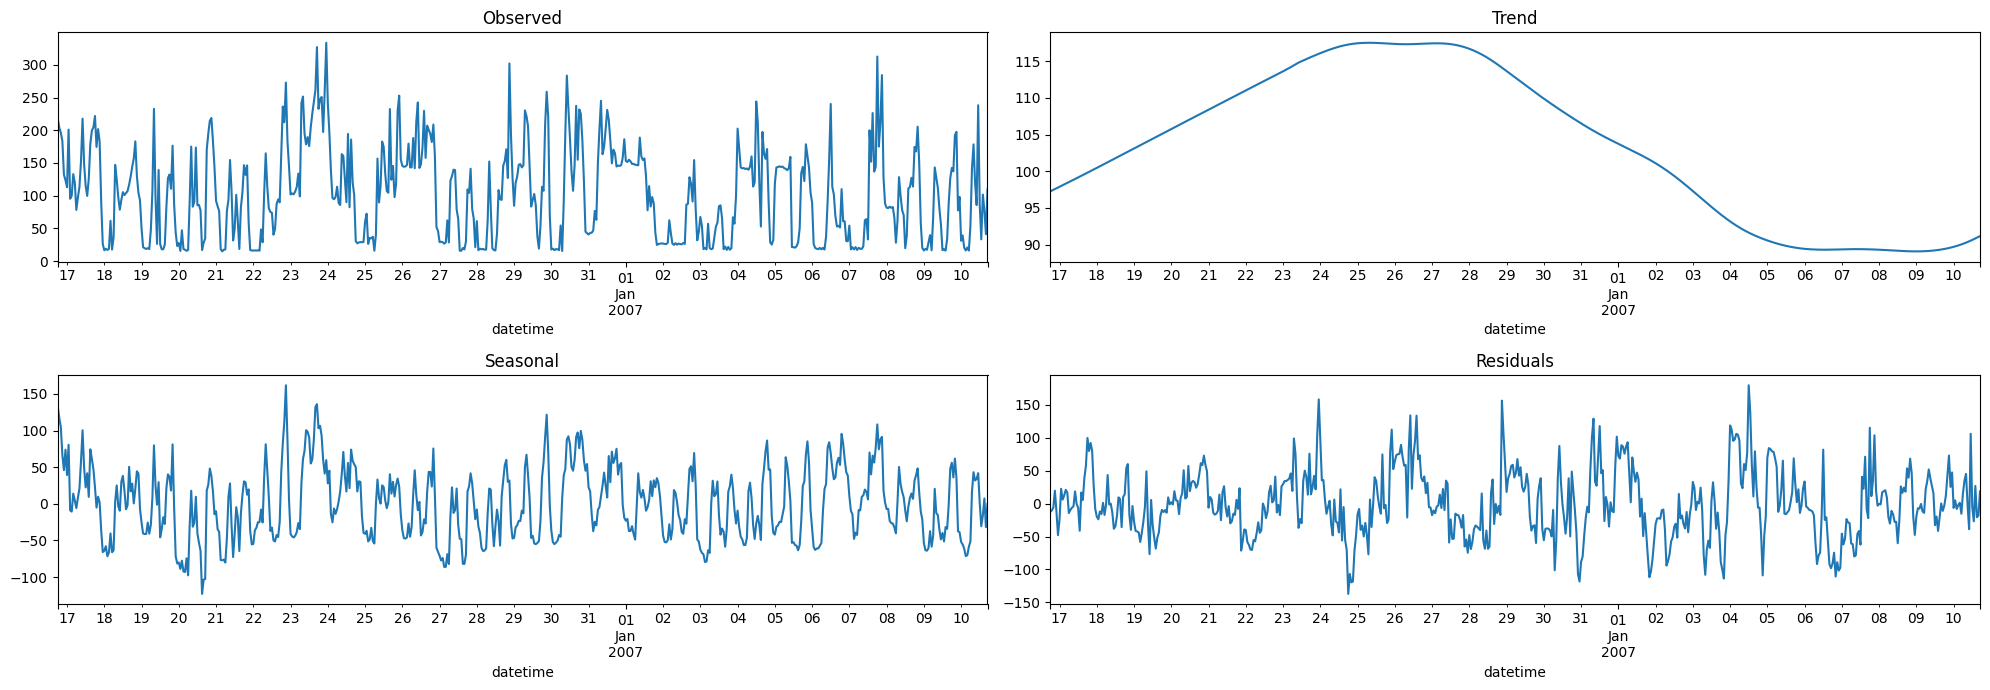

In [17]:
weekly_decomposition = STL(train['Global_active_power'], period=168).fit() # since the data is hourly, we use 168 hours (one week) as the period

plt.figure(figsize=(20,7))

plt.subplot(2,2,1)
weekly_decomposition.observed.iloc[:600].plot()
plt.title('Observed')

plt.subplot(2,2,2)
weekly_decomposition.trend.iloc[:600].plot()
plt.title('Trend')

plt.subplot(2,2,3)
weekly_decomposition.seasonal.iloc[:600].plot()
plt.title('Seasonal')

plt.subplot(2,2,4)
weekly_decomposition.resid.iloc[:600].plot()
plt.title('Residuals')

plt.tight_layout()
plt.show()

For both the daily and weekly decomposition, there is no apparent trend. However, some form of seasonality for daily and weekly periods is present.  Let's do some Fourier Transform to ensure which seasonality is present. We will use a **Periodogram.**

The Fourier transform decomposes a signal into a set of frequencies, allowing for us to determine the dominant frequencies that make up a time series. A periodogram is a type of spectral density estimate that shows how the variance of the data is distributed over different frequencies. It's particularly useful for identifying dominant frequencies (or periods) within a dataset, which can indicate seasonality or cyclical patterns.

Using a periodogram, you can visualize the power or energy of your data's variations at different frequencies. Peaks in the periodogram indicate frequencies at which the data exhibits strong cyclical behavior, making it a valuable tool for seasonality detection.

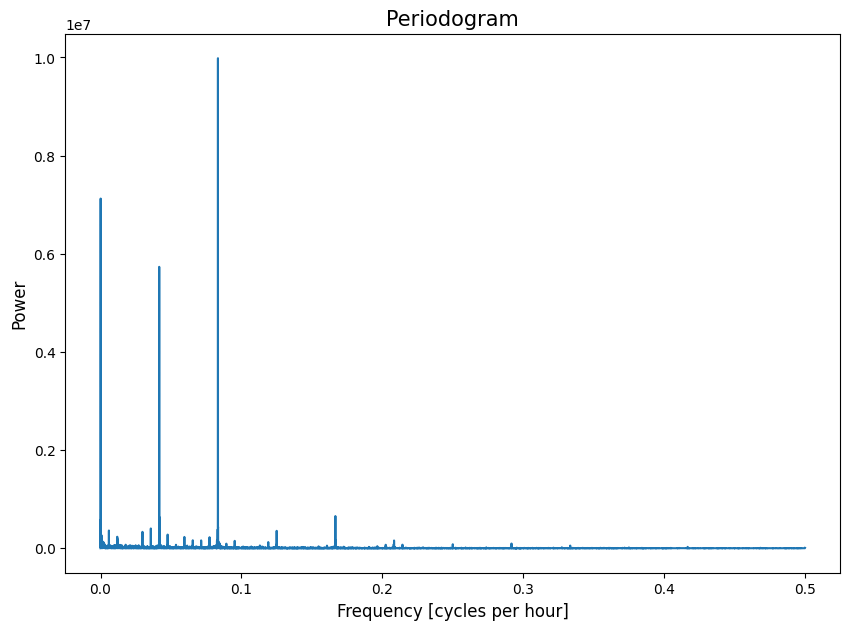

In [120]:
# Sampling frequency: 1 hour (the time unit is hours)
fs = 1

# Compute periodogram
frequencies, power = periodogram(train['Global_active_power'].values, fs)

# Plot the periodogram
plt.figure(figsize=(10,7))
plt.plot(frequencies, power)
plt.xlabel('Frequency [cycles per hour]', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('Periodogram', fontsize=15)
plt.show()

In [153]:
# identifying the top three dominant frequencies

top_3_freqs = frequencies[np.argsort(power)[-3:]][::-1]

# Compute the corresponding periods
top_3_periods = 1 / top_3_freqs

print("==============\nTop 3 periods:\n==============")

for i, period in enumerate(top_3_periods):
    print(f"Period {i+1}: {period:.2f} hours or {period/24:.2f} days")

Top 3 periods:
Period 1: 12.00 hours or 0.50 days
Period 2: 9223.00 hours or 384.29 days
Period 3: 24.00 hours or 1.00 days


The top 3 seasonal periods are 12 hours, 9223 hours, and 24 hours. Indeed, we have a daily seasonal cycle, but the most dominant seasonality is 12 hours. The second dominant seasonal cycle doesn't make sense for our analysis, and there is no weekly seasonality. Our sine and cosine transformations are indeed very beneficial. 

## Store Data

Let's store our data for later use.

In [16]:
train_df=train.iloc[:int(n*.7)]
val_df=train.iloc[int(n*.7):]
test_df= test.copy()

train_df.to_parquet('data/train.parquet', compression='gzip')
val_df.to_parquet('data/val.parquet', compression='gzip')
test_df.to_parquet('data/test.parquet', compression='gzip')

print(f"train_df shape: {train_df.shape}")
print(f"val_df shape: {val_df.shape}")
print(f"test_df shape: {test_df.shape}")

train_df shape: (24210, 9)
val_df shape: (3459, 9)
test_df shape: (6918, 9)
